#### 类别预测和边界框预测

In [6]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


# 类别预测层
# 输入为rgb 3个通道，每个像素点生成5个锚框，共有10个类别
# 则这个函数输出为5*(10+1)=55，也即每个锚框对应每个类别的概率特征图
def cls_predictor(num_inputs, num_anchors, num_classes):
    """
    num_inputs: 输入通道数
    num_anchors: 每个像素点的锚框数量
    num_classes: 类别数
    """
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

# 边界框预测层，为每个锚框预测4个偏移量
def bbox_predictor(num_inputs, num_anchors):
    """
    num_inputs: 输入通道数
    num_anchors: 每个像素点的锚框数量
    """
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

def forward(x, block):
    """return block(x)"""
    return block(x)

In [7]:
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), bbox_predictor(16, 5))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 20, 10, 10]))

在你提供的代码片段中，`nn.BatchNorm2d(out_channels)` 和 `return nn.Sequential(*blk)` 都是PyTorch框架中常用的构造。让我们逐一解答你的问题。

1. **`nn.BatchNorm2d(out_channels)` 的作用：**

   `nn.BatchNorm2d` 是一个批归一化（Batch Normalization）层，它用于加速训练、稳定模型的学习过程，并且可以在一定程度上起到正则化的效果，从而减少过拟合的风险。具体来说，`nn.BatchNorm2d` 对每个小批次的数据（batch）进行归一化处理，即对每个特征图中的所有神经元的输出值进行均值为0、方差为1的标准化，然后再通过两个可学习参数（gamma和beta）缩放和平移这些标准化后的值。这样做可以确保每一层的输入都有相对稳定的分布，从而有助于缓解内部协变量偏移（internal covariate shift）的问题，提高网络的泛化能力。

2. **`return nn.Sequential(*blk)` 中的 `*blk` 用法：**

   在Python中，星号 `*` 用于解包（unpacking）序列或迭代器。当在函数调用中使用时，它会将序列或迭代器中的元素作为单独的位置参数传递给函数。这与C或C++中的指针完全不同；这里没有涉及内存地址的操作。

   在这个例子中，`blk` 是一个列表，其中包含了多个层对象（如卷积层、批归一化层、ReLU激活函数和最大池化层）。`nn.Sequential` 接受多个层作为其参数，并将它们按顺序组合成一个单一的模块。因此，`*blk` 将列表 `blk` 中的所有元素解包为独立的参数传递给 `nn.Sequential` 构造函数，使得 `nn.Sequential` 可以正确地初始化包含所有这些层的序列模块。

例如，如果你有如下定义：

```python
layers = [layer1, layer2, layer3]
seq = nn.Sequential(*layers)
```

那么这等价于：

```python
seq = nn.Sequential(layer1, layer2, layer3)
```

这样，`nn.Sequential` 模块就能按照添加的顺序依次应用这些层到输入数据上了。

In [8]:
def flatten_pred(pred):
    """将pred按照0,(2,3,1)的维度顺序展平为2维"""
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    """将每个preds按照第1维度连接起来(第0维(通道数)保持不变)"""
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

def down_sample_blk(in_channels, out_channels):
    """
    高度和宽度减半块
    in_channels : 输入通道数
    out_channels : 输出通道数
    填充为1的3*3卷积层不改变特征图的形状。但是其后的2*2的最大汇聚层将输入特征图的高度和宽度减少了一半
    """
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

def base_net():
    """"
    基本网络块,由3个高度和宽度减半块组成
    转化后图片由(2,3,256,256)->(2, 64, 32, 32)
    """

    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

## 完整的模型

In [9]:
def get_blk(i):
    """"
    完整的单发多框检测模型由五个模块组成。
    每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。
    在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。
    """
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk


def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    """
    现在我们为每个块定义前向传播。与图像分类任务不同，
    此处的输出包括:CNN特征图Y,在当前尺度下根据Y生成的锚框,预测的这些锚框的类别和偏移量(基于Y)
    """
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1


class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds


## 训练模型

In [10]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [11]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [12]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    """ 掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。 
    最后，我们将锚框类别和偏移量的损失相加，以获得模型的最终损失函数。"""
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.62e-03, bbox mae 3.72e-03
943.1 examples/sec on cpu


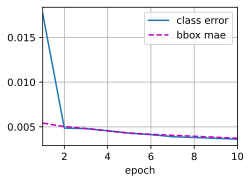

In [11]:
num_epochs, timer = 10, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## 运行和保存模型

In [6]:
X = torchvision.io.read_image('../data/banana-detection/91.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()


def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]


def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')


In [ ]:
output = predict(X)
display(img, output.cpu(), threshold=0.9)

In [ ]:
torch.save(net.state_dict(), 'banana.params')

d:\Users\liu.yihang2\AppData\Local\anaconda3\envs\yolov8\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


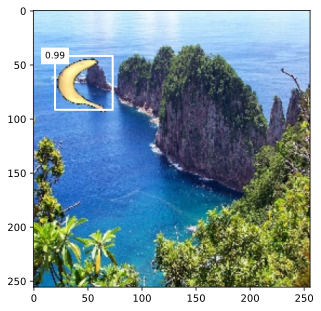

In [8]:
device = d2l.try_gpu()
clone = TinySSD(1)
clone.load_state_dict(torch.load('banana.params'))
clone.eval()

net = clone
output = predict(X)

display(img, output.cpu(), threshold=0.9)